# Task 4: industry level
> Abdelrahman Ahmed Abdrabo

---
Description:
 - Dataset (Recommended): GTSRB (Kaggle
 - Classify traffic signs based on their image using deep learning
 - Preprocess images (resizing, normalization)
 - Train a CNN model to recognize different traffic sign classes
 - Evaluate performance using accuracy and confusion matrix

---
Table of content:

1. Import modules and data
2. Data understanding
3. Model training
4. Bonus work: use MobileNet


# 1. Import modules and data


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

2025-07-23 00:42:51.613448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753231371.811967      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753231371.866883      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
TRAIN_FOLDER = '/kaggle/input/gtsrb-german-traffic-sign/train'
CSV_FILE = '/kaggle/input/gtsrb-german-traffic-sign/Train.csv'

num_of_categories = len(os.listdir(TRAIN_FOLDER))
num_of_categories

43

# 2. Data understanding


In [3]:
folders = os.listdir(TRAIN_FOLDER)
images = []
classes = []
for folder in folders:
    images.append(len(os.listdir(TRAIN_FOLDER + '/' + folder)))
    classes.append(int(folder))

data = pd.DataFrame({'Class': classes, 'Image_Count': images})
data.head()

,Class,Image_Count
0,7,1440
1,17,1110
2,19,210
3,22,390
4,2,2250


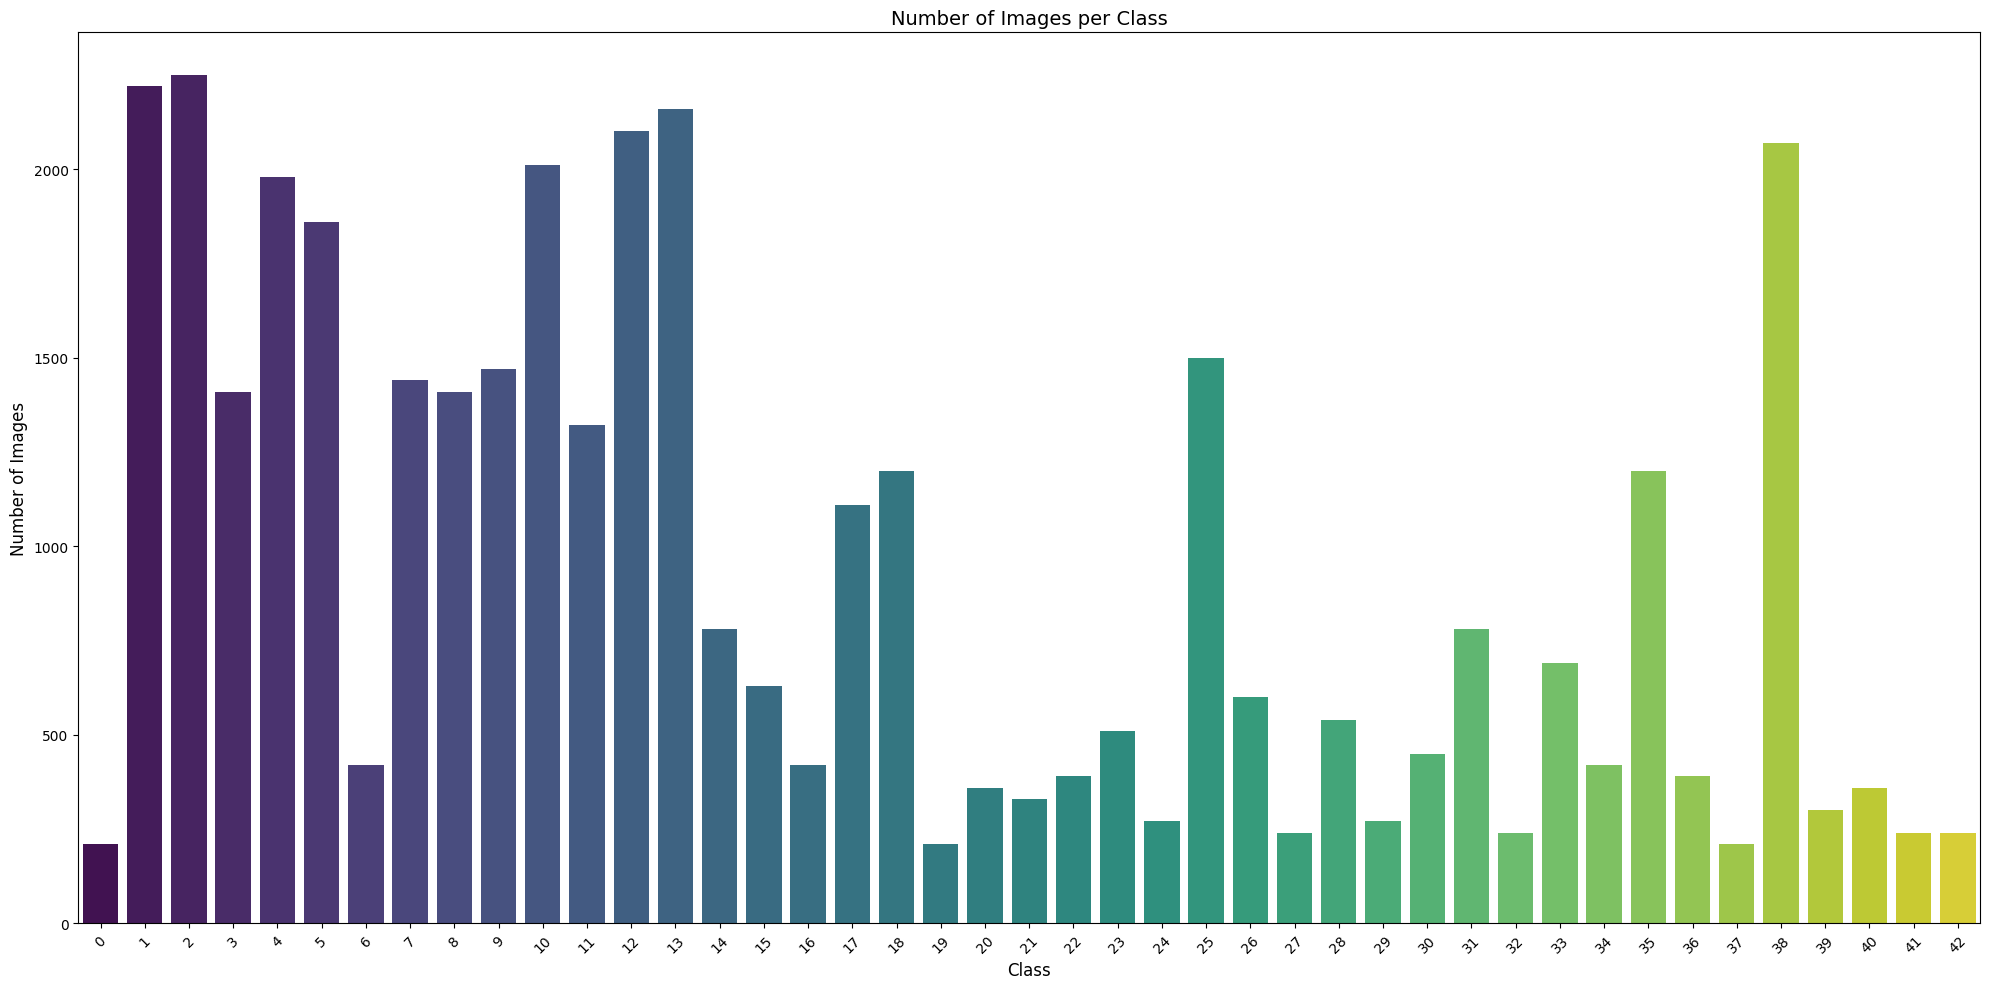

In [4]:
plt.figure(figsize=(20, 10))
sns.barplot(x='Class', y='Image_Count', data=data, palette='viridis')

plt.title('Number of Images per Class', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [5]:
IMG_HEIGHT, IMG_WIDTH = 32, 32
BATCH_SIZE = 32
df = pd.read_csv(CSV_FILE)
df

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


In [6]:
edit_pth = '/kaggle/input/gtsrb-german-traffic-sign'
df['Path'] = df['Path'].apply(lambda x: os.path.join(edit_pth, x))
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,/kaggle/input/gtsrb-german-traffic-sign/Train/...
1,28,27,5,6,23,22,20,/kaggle/input/gtsrb-german-traffic-sign/Train/...
2,29,26,6,5,24,21,20,/kaggle/input/gtsrb-german-traffic-sign/Train/...
3,28,27,5,6,23,22,20,/kaggle/input/gtsrb-german-traffic-sign/Train/...
4,28,26,5,5,23,21,20,/kaggle/input/gtsrb-german-traffic-sign/Train/...


In [7]:
df.Path[0]

'/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00000.png'

In [8]:
df['ClassId'] = df['ClassId'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  object
 7   Path     39209 non-null  object
dtypes: int64(6), object(2)
memory usage: 2.4+ MB


In [9]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClassId'], random_state=42)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator with only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='ClassId',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 31367 validated image filenames belonging to 43 classes.


In [12]:
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Path',
    y_col='ClassId',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 7842 validated image filenames belonging to 43 classes.


In [13]:
print("Training class indices:", train_generator.class_indices)
print("Validation class indices:", validation_generator.class_indices)
train_generator.class_indices == validation_generator.class_indices

Training class indices: {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '5': 38, '6': 39, '7': 40, '8': 41, '9': 42}
Validation class indices: {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '5': 38, '6': 39, '7': 40, '8': 41, '9': 42}


True

# 3. Model training


In [14]:
num_classes = len(train_generator.class_indices)

model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1753231464.720444      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,203 (453.92 KB)

 Trainable params: 115,755 (452.17 KB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=early_stop
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1753231471.074493      96 service.cc:148] XLA service 0x7a86a00020c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753231471.075244      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753231471.600342      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/981 ━━━━━━━━━━━━━━━━━━━━ 2:34:48 9s/step - accuracy: 0.0000e+00 - loss: 5.2339

I0000 00:00:1753231476.113182      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


981/981 ━━━━━━━━━━━━━━━━━━━━ 215s 210ms/step - accuracy: 0.0775 - loss: 3.7581 - val_accuracy: 0.1912 - val_loss: 3.0312
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 60s 61ms/step - accuracy: 0.1594 - loss: 3.0871 - val_accuracy: 0.2424 - val_loss: 2.7411
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 63s 64ms/step - accuracy: 0.2092 - loss: 2.8356 - val_accuracy: 0.2520 - val_loss: 2.5514
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.2542 - loss: 2.6397 - val_accuracy: 0.3308 - val_loss: 2.2564
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.3008 - loss: 2.4290 - val_accuracy: 0.4007 - val_loss: 1.9895
Epoch 6/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.3452 - loss: 2.2027 - val_accuracy: 0.4606 - val_loss: 1.7292
Epoch 7/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.3940 - loss: 2.0093 - val_accuracy: 0.4703 - val_loss: 1.6387
Epoch 8/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.4148 - loss: 1.8713 - val_accur

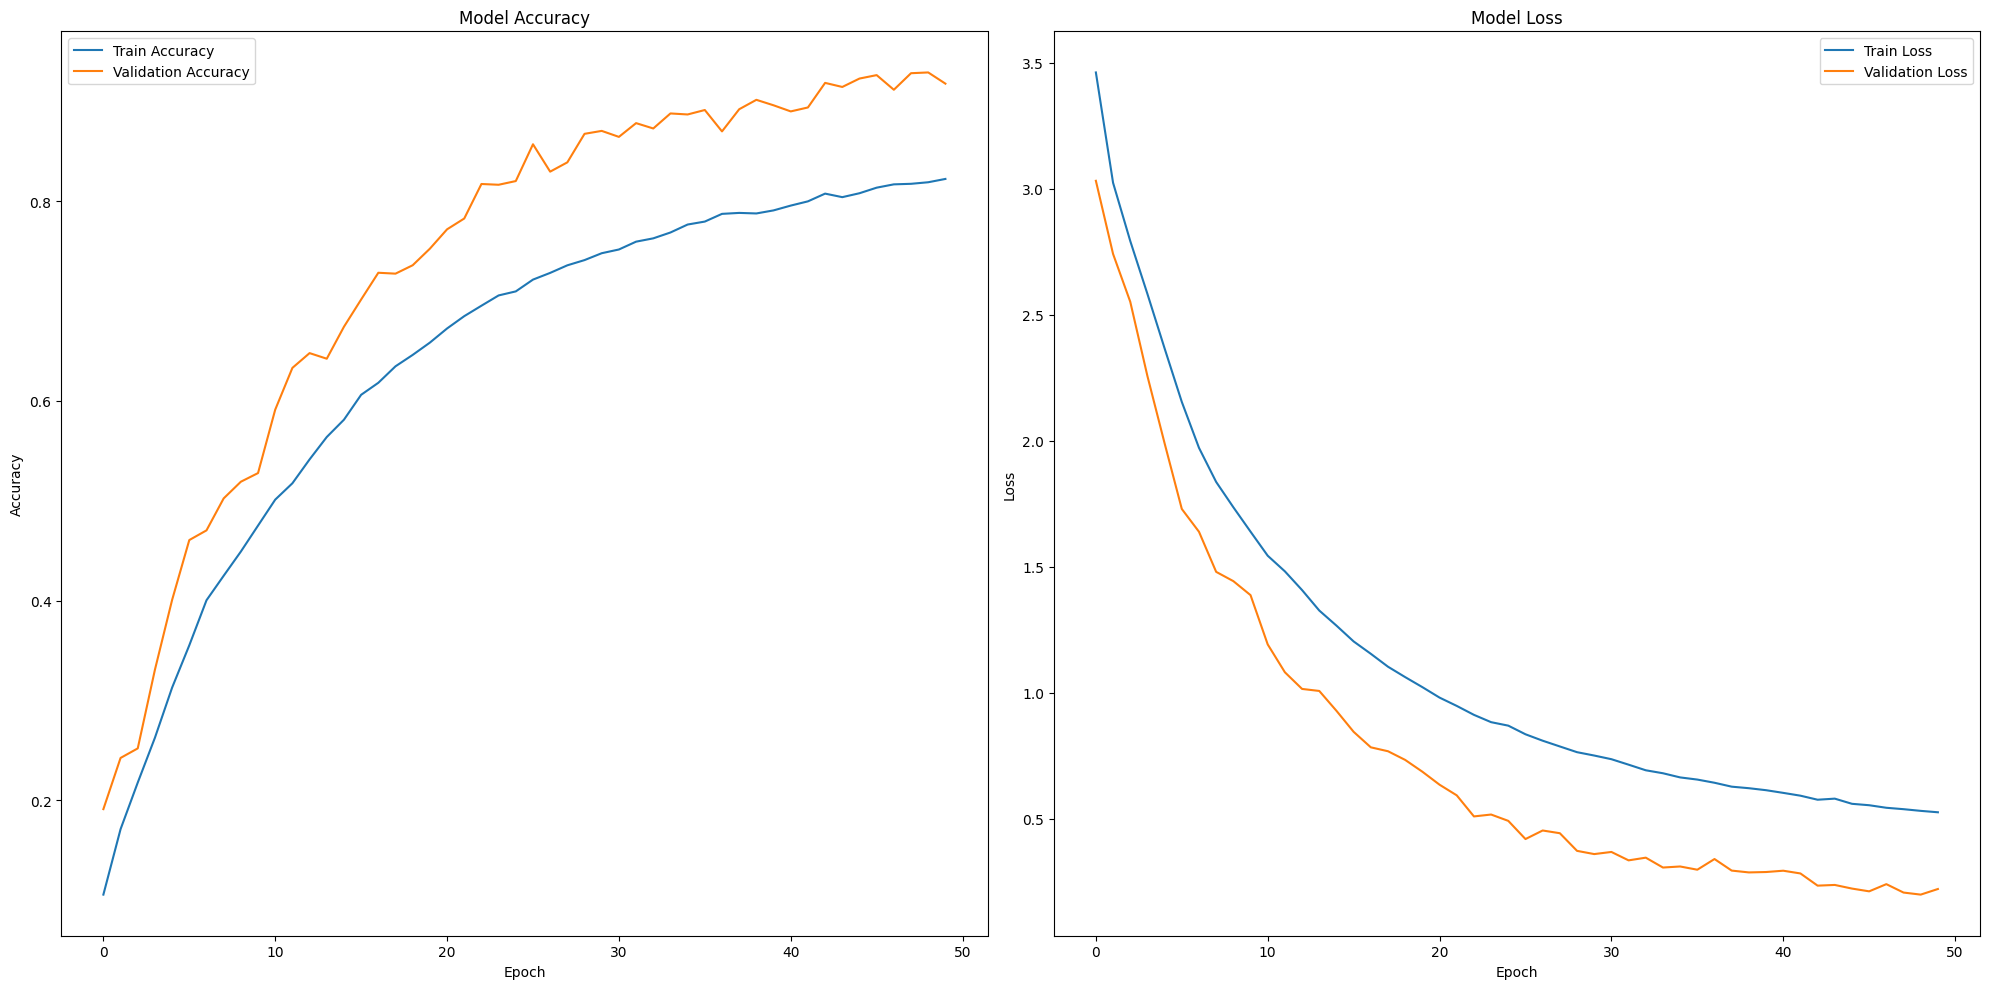

In [16]:
plt.figure(figsize=(20, 10))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
TEST_FOLDER = '/kaggle/input/gtsrb-german-traffic-sign'
TEST_CSV = '/kaggle/input/gtsrb-german-traffic-sign/Test.csv'
test_df = pd.read_csv(TEST_CSV)
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [18]:
test_df['Path'] = test_df['Path'].apply(lambda x: os.path.join(TEST_FOLDER, x))

In [19]:
test_df['ClassId'] = test_df['ClassId'].astype(str)

In [20]:
test_df

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,/kaggle/input/gtsrb-german-traffic-sign/Test/0...
1,42,45,5,5,36,40,1,/kaggle/input/gtsrb-german-traffic-sign/Test/0...
2,48,52,6,6,43,47,38,/kaggle/input/gtsrb-german-traffic-sign/Test/0...
3,27,29,5,5,22,24,33,/kaggle/input/gtsrb-german-traffic-sign/Test/0...
4,60,57,5,5,55,52,11,/kaggle/input/gtsrb-german-traffic-sign/Test/0...
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,/kaggle/input/gtsrb-german-traffic-sign/Test/1...
12626,50,51,6,5,45,46,33,/kaggle/input/gtsrb-german-traffic-sign/Test/1...
12627,29,29,6,6,24,24,6,/kaggle/input/gtsrb-german-traffic-sign/Test/1...
12628,48,49,5,6,43,44,7,/kaggle/input/gtsrb-german-traffic-sign/Test/1...


In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='ClassId',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 12630 validated image filenames belonging to 43 classes.


In [22]:
# Get predictions
test_generator.reset()
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}
images, labels = next(test_generator)
images = images[:20]
labels = labels[:20]
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


395/395 ━━━━━━━━━━━━━━━━━━━━ 67s 168ms/step


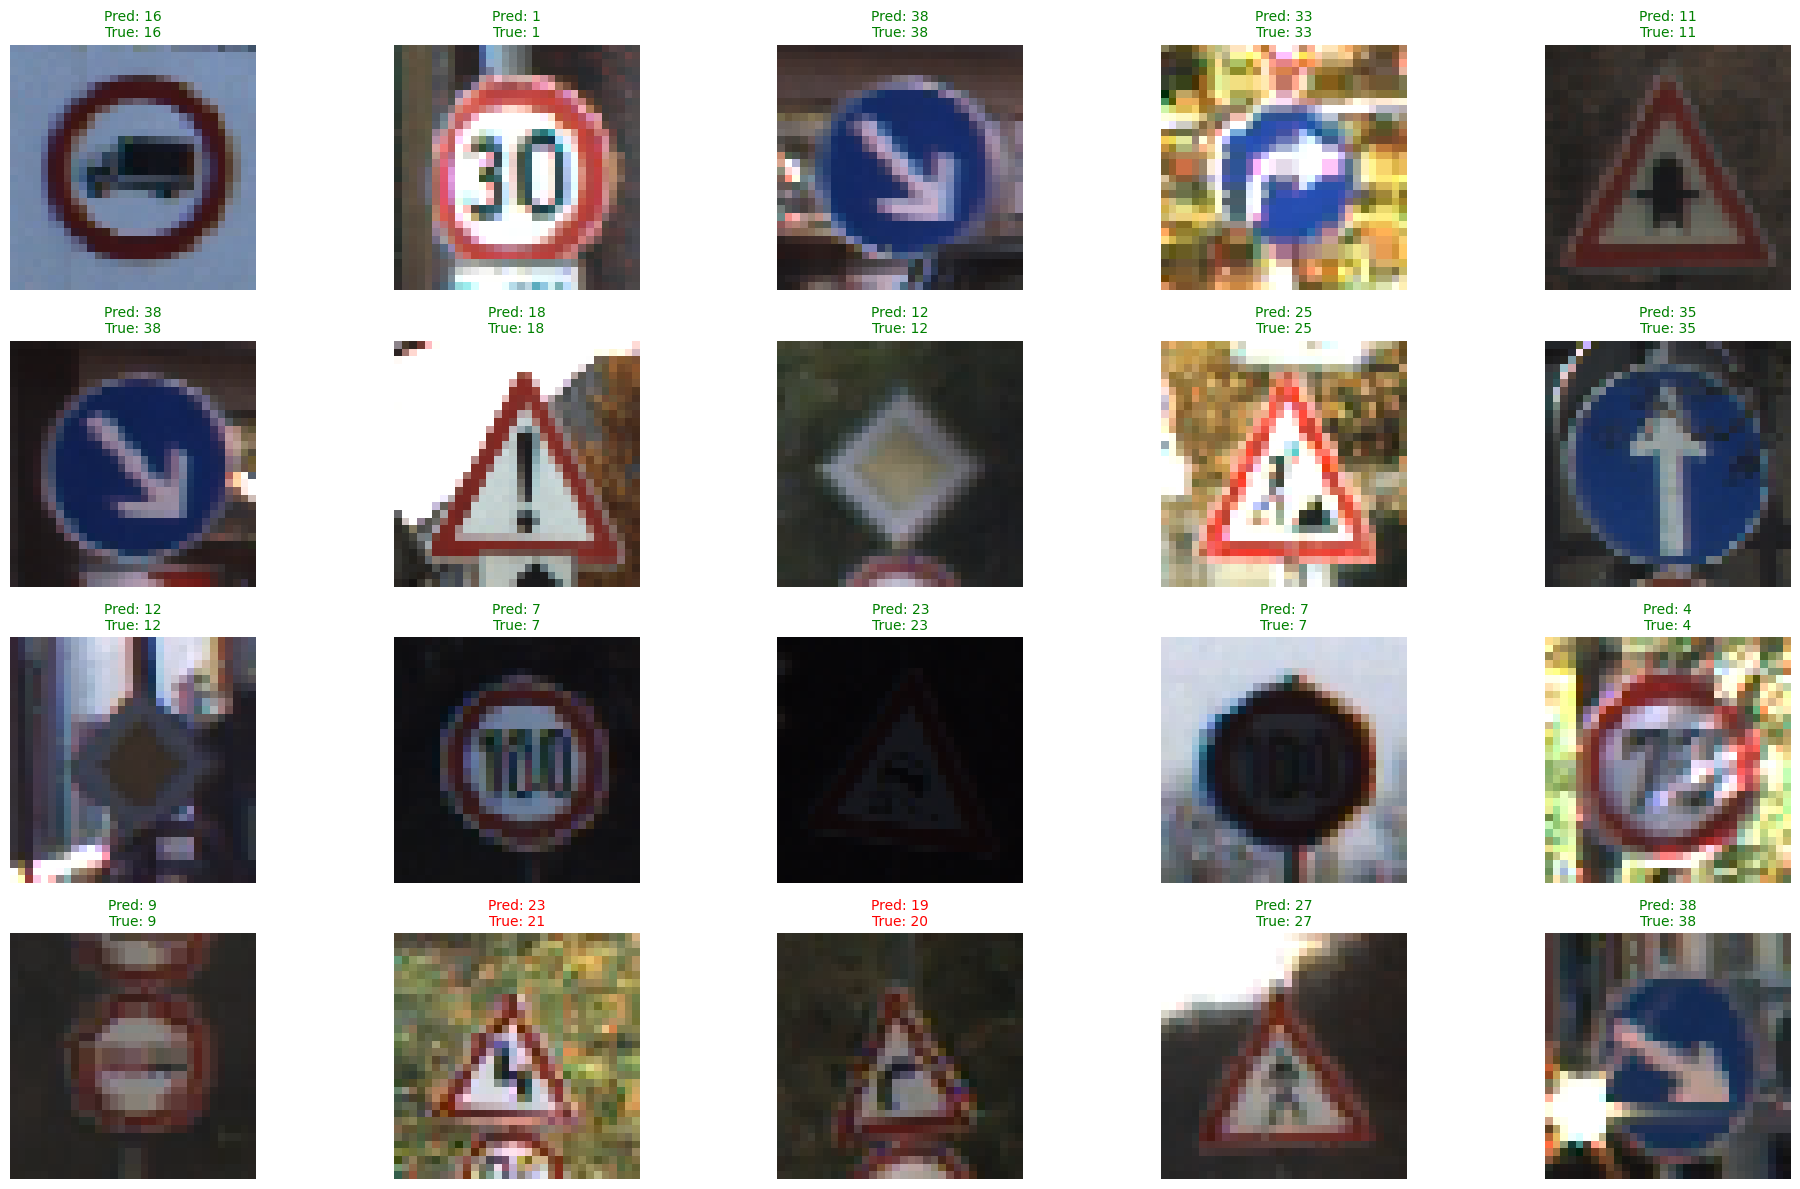

In [23]:
plt.figure(figsize=(20, 12))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    pred_label = class_names[predicted_classes[i]]
    true_label = class_names[true_classes[i]]
    title_color = 'green' if predicted_classes[i] == true_classes[i] else 'red'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=title_color, fontsize=10)
plt.tight_layout()
plt.show()

In [24]:
test_generator.reset()
test_loss, test_acc = model.evaluate(test_generator)
f"Validation Loss: {test_loss}, Validation Accuracy: {test_acc}"

395/395 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.8654 - loss: 0.4214


'Validation Loss: 0.42809271812438965, Validation Accuracy: 0.8624703288078308'

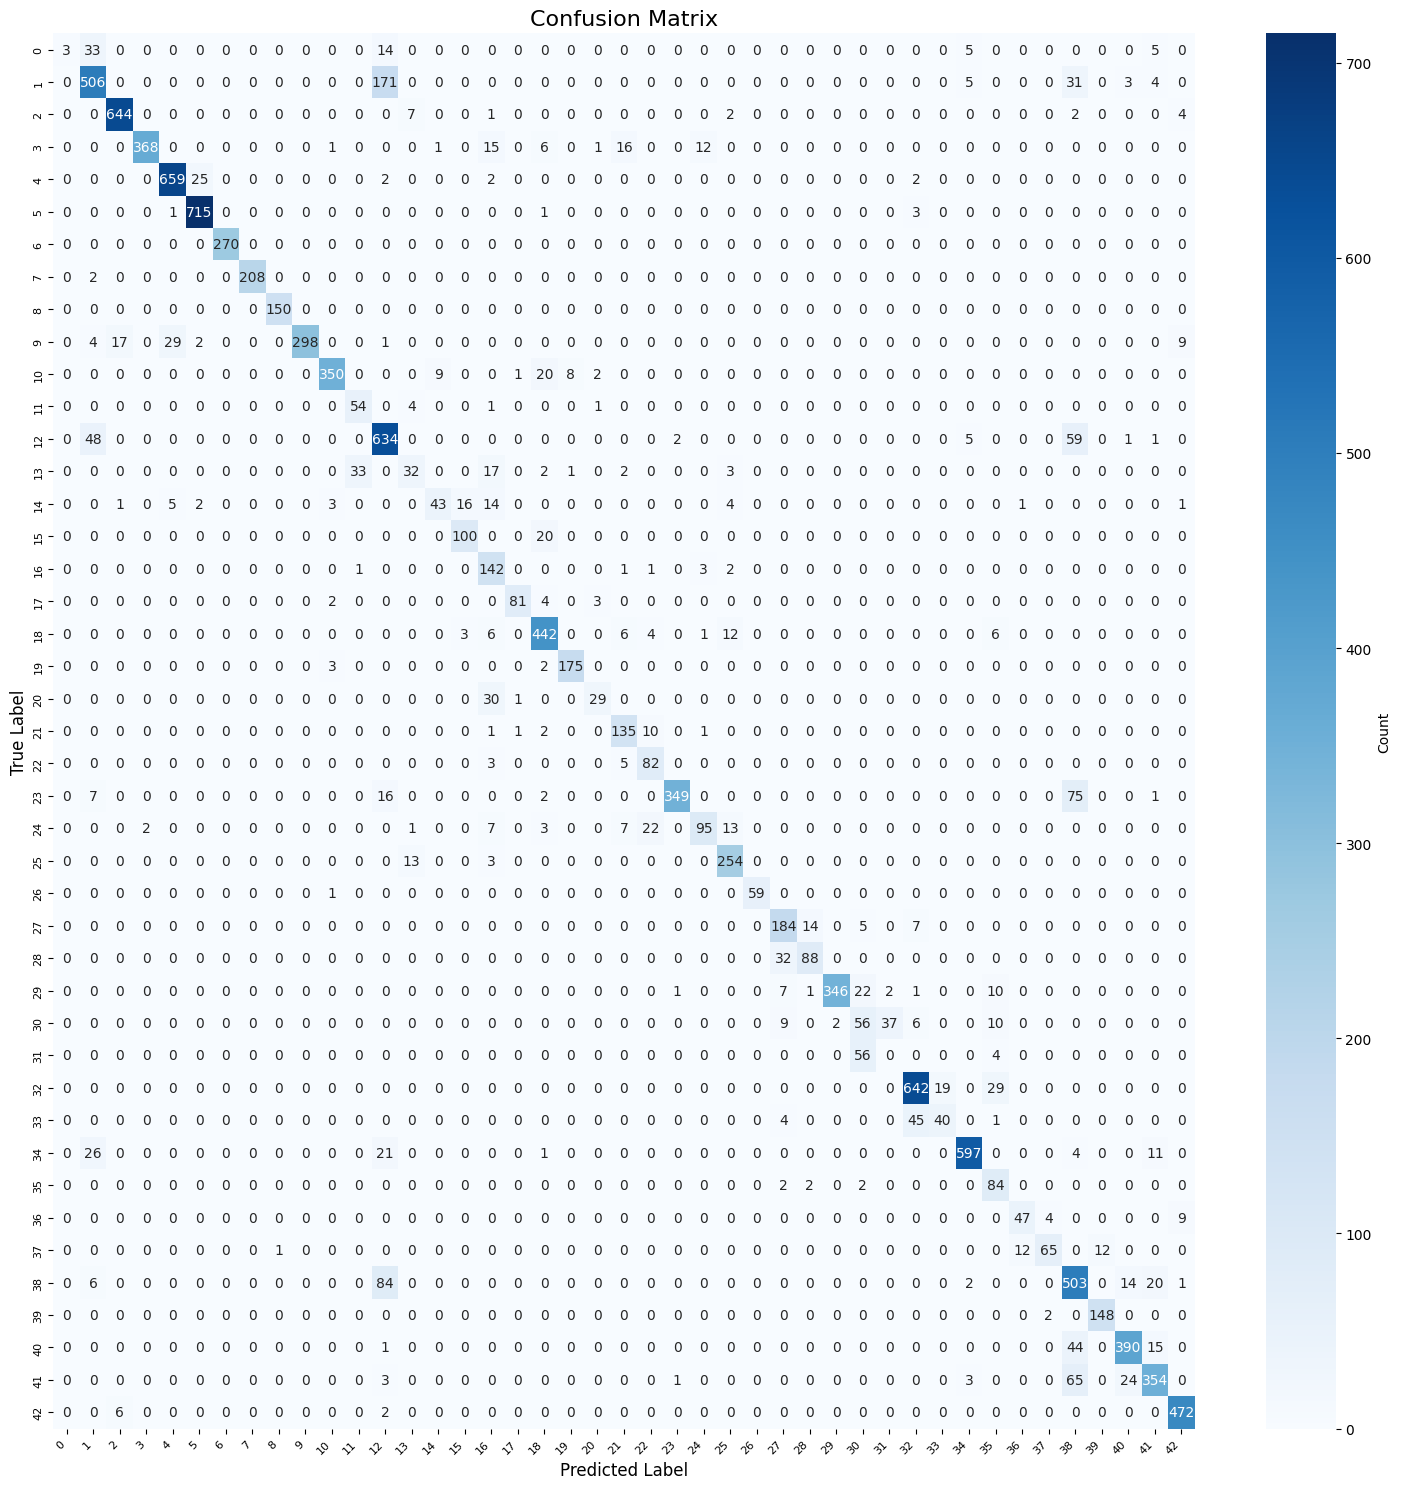

In [25]:
# Plot Confusion Matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'},
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# 4. Bonus work: use MobileNet

In [26]:
# Load MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    # alpha=0.5,
    include_top=False,
    weights='imagenet',
)

# base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_mobile = Model(inputs=base_model.input, outputs=predictions)

model_mobile.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_mobile.summary()

/tmp/ipykernel_36/1340746495.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 2,427,499 (9.26 MB)

 Trainable params: 2,393,387 (9.13 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [27]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model_mobile.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=early_stop
)

Epoch 1/50


E0000 00:00:1753234744.681292      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753234744.853453      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753234745.174093      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753234745.357788      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


981/981 ━━━━━━━━━━━━━━━━━━━━ 142s 86ms/step - accuracy: 0.2425 - loss: 2.9041 - val_accuracy: 0.1183 - val_loss: 4.4447
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 63s 64ms/step - accuracy: 0.4928 - loss: 1.6859 - val_accuracy: 0.3911 - val_loss: 3.4041
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 62s 63ms/step - accuracy: 0.5987 - loss: 1.3000 - val_accuracy: 0.4686 - val_loss: 2.1562
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 61s 63ms/step - accuracy: 0.6464 - loss: 1.1707 - val_accuracy: 0.4949 - val_loss: 2.2601
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - accuracy: 0.6199 - loss: 1.2316 - val_accuracy: 0.4578 - val_loss: 2.2227
Epoch 6/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 61s 63ms/step - accuracy: 0.6498 - loss: 1.1503 - val_accuracy: 0.3528 - val_loss: 4.0970
Epoch 7/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 62s 63ms/step - accuracy: 0.5459 - loss: 1.5062 - val_accuracy: 0.2688 - val_loss: 2.6603
Epoch 8/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 64s 65ms/step - accuracy: 0.6552 - loss: 1.0715 - val_accura

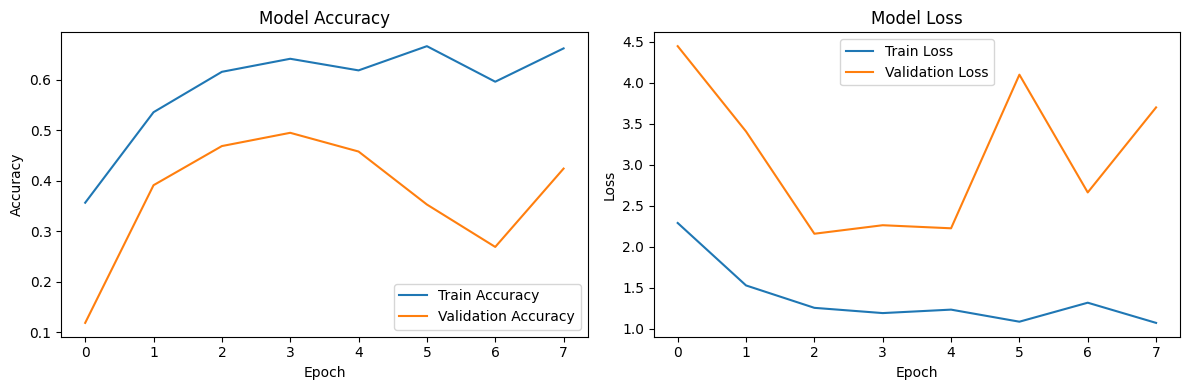

In [28]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Get predictions
test_generator.reset()
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}
images, labels = next(test_generator)
images = images[:20]
labels = labels[:20]
predictions = model_mobile.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

395/395 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step


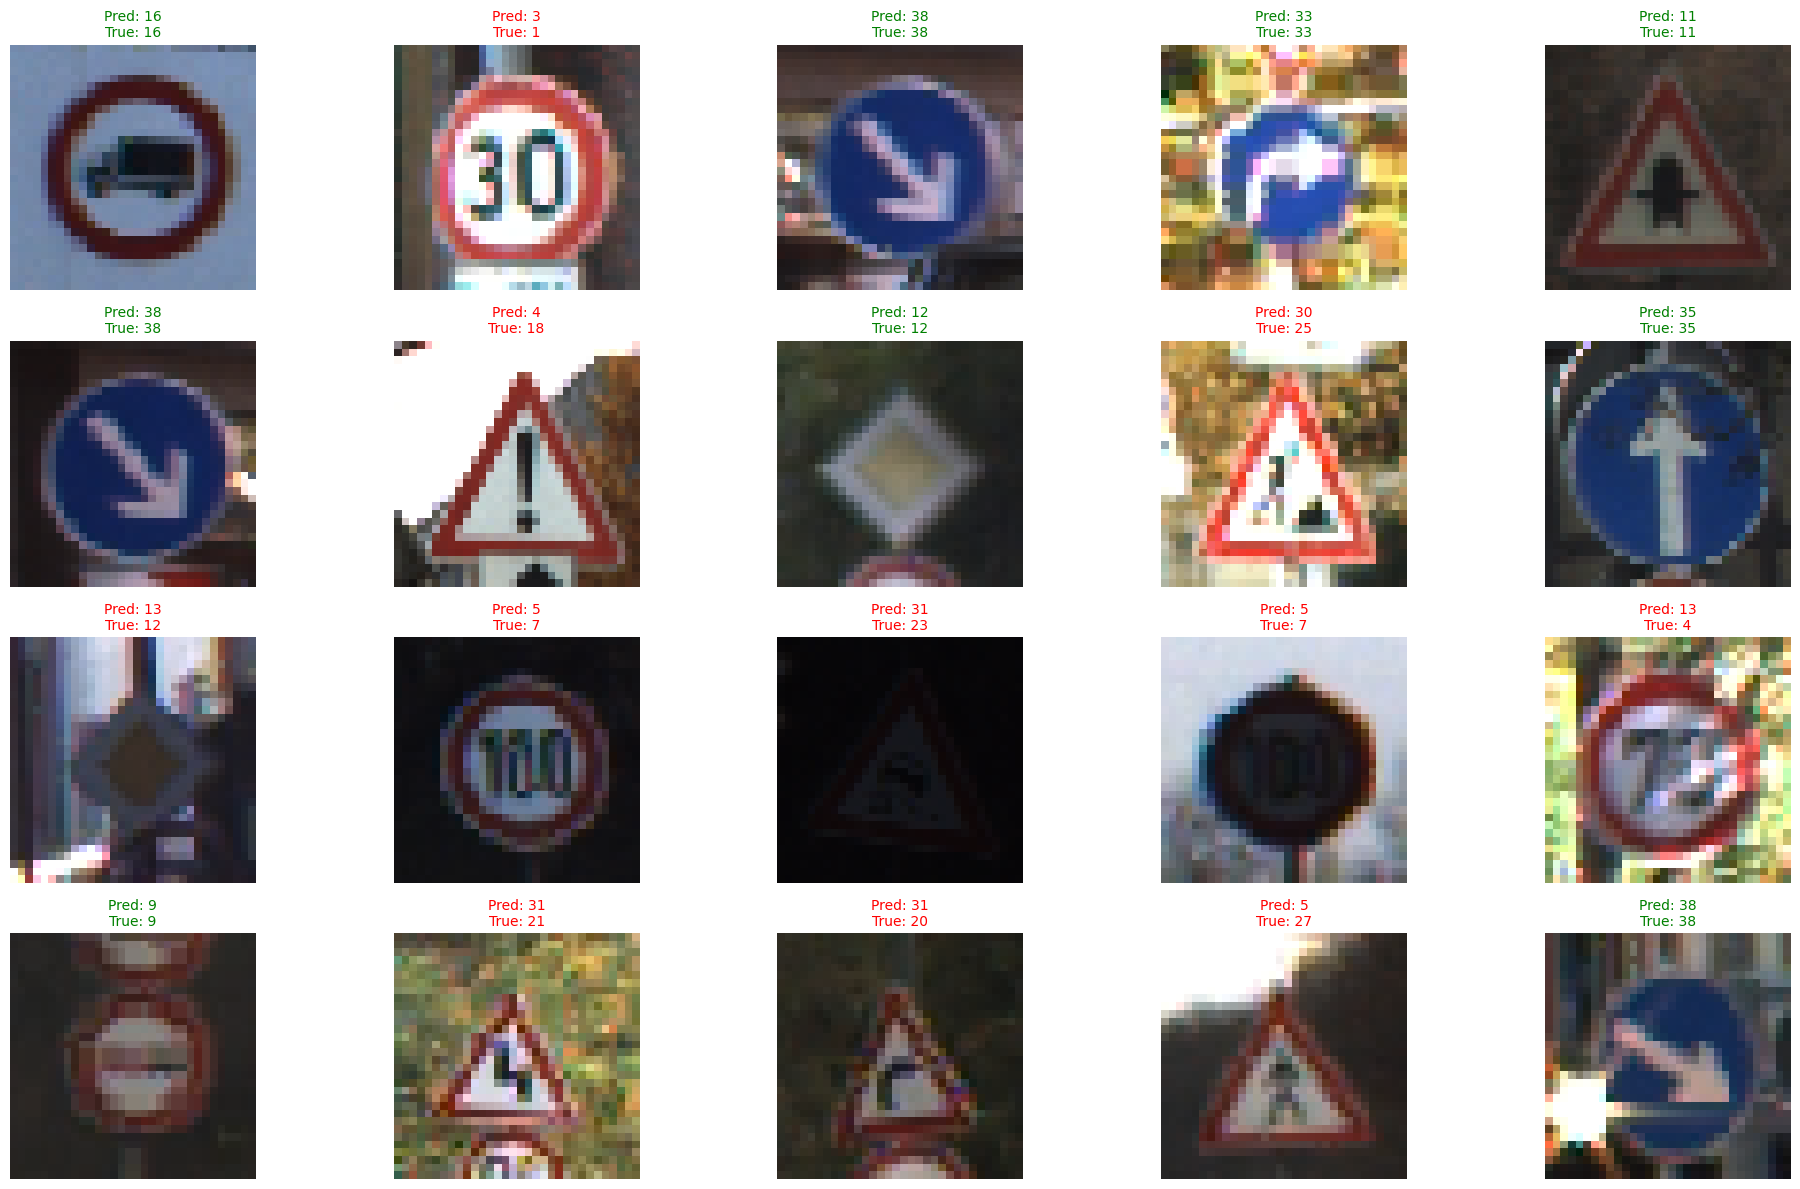

In [30]:
plt.figure(figsize=(20, 12))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    pred_label = class_names[predicted_classes[i]]
    true_label = class_names[true_classes[i]]
    title_color = 'green' if predicted_classes[i] == true_classes[i] else 'red'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=title_color, fontsize=10)
plt.tight_layout()
plt.show()

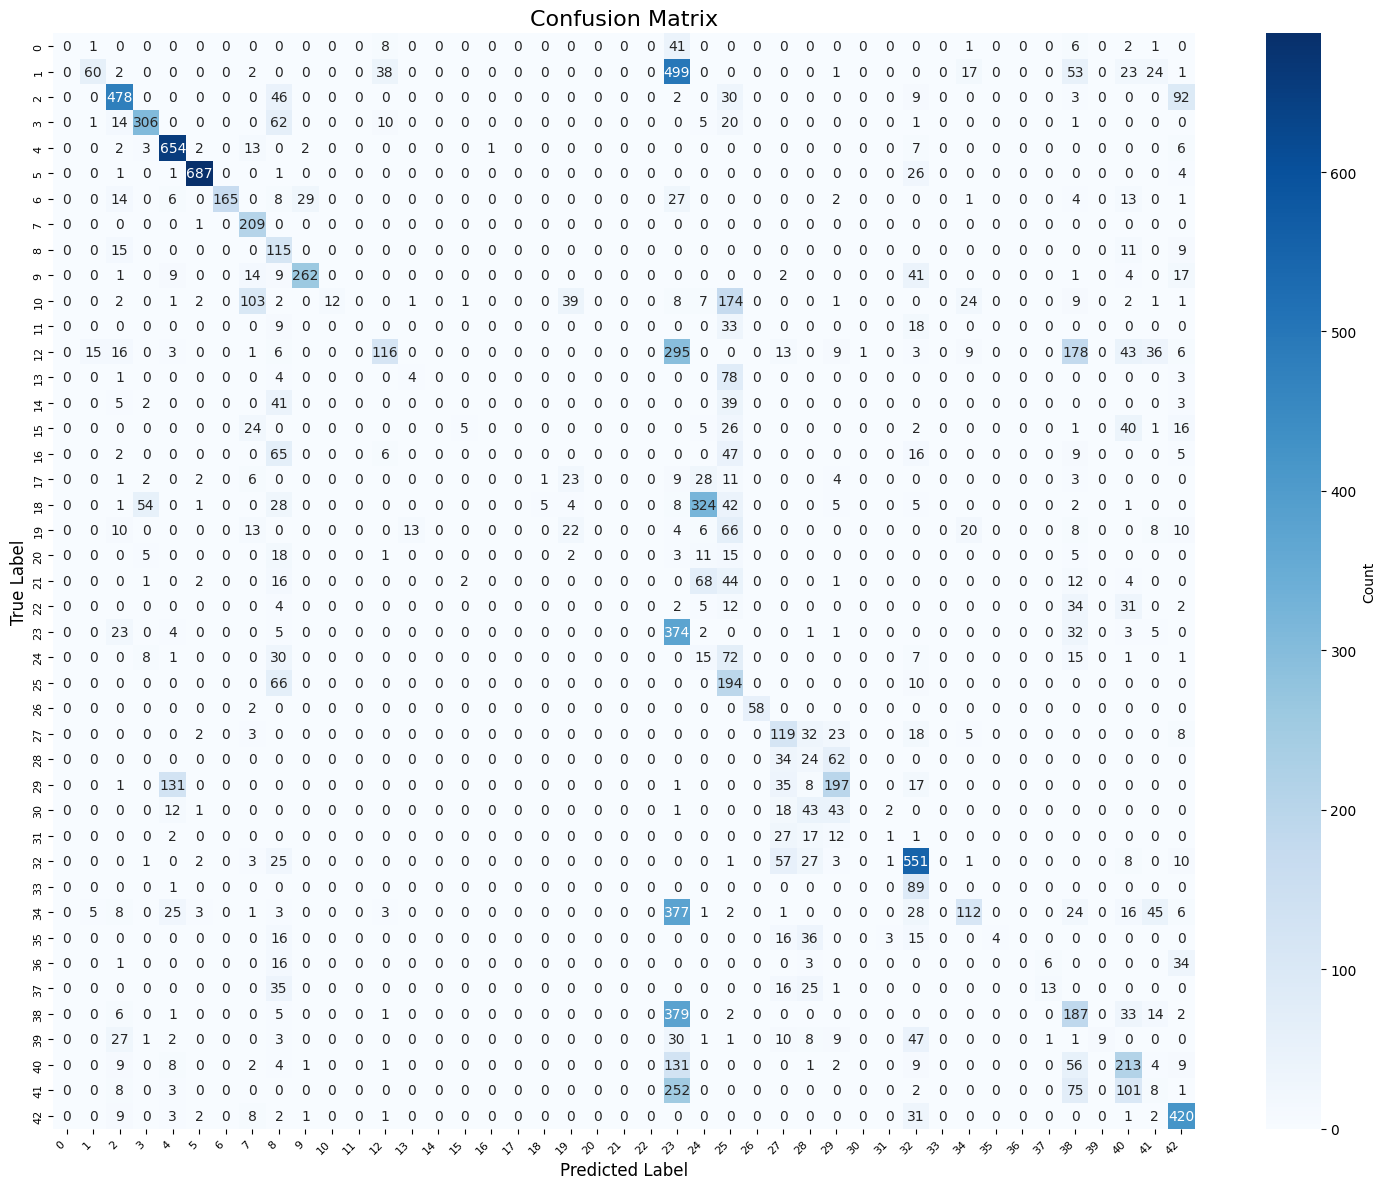

In [31]:
# Plot Confusion Matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'},
            xticklabels=range(43), yticklabels=range(43))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Thanks